Imports

In [2]:
# Import necessari
import cv2
import numpy as np
import os
import pickle
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import json
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

Canny edge detection

In [20]:


# Load an image
image = cv2.imread(r'C:\Users\loren\Downloads\APKLOT-master\APKLOT-master\1. Satellite\Dataset\parcheggi\Dataset\402492112_training.png')

# Get the edge image
edge_image = get_edge_image(image, low_threshold=250, high_threshold=350)

# Display the edge image
cv2.imshow('Edge Image', edge_image)
cv2.waitKey(0)

-1

Key: shapes
[{'label': '1', 'line_color': None, 'fill_color': None, 'points': [[1057, 49], [1101, 5], [1346, 8], [1355, 23], [1327, 56]]}
 {'label': '1', 'line_color': None, 'fill_color': None, 'points': [[1361, 53], [1382, 24], [1398, 8], [1708, 13], [1755, 17], [1790, 21], [1796, 27], [1762, 64]]}
 {'label': '1', 'line_color': None, 'fill_color': None, 'points': [[1888, 90], [1940, 138], [1939, 168], [1919, 188], [1886, 148]]}
 {'label': '1', 'line_color': None, 'fill_color': None, 'points': [[1883, 212], [1924, 181], [1936, 196], [1930, 206], [1933, 232], [1881, 272]]}
 {'label': '1', 'line_color': None, 'fill_color': None, 'points': [[1879, 269], [1931, 270], [1931, 289], [1927, 296], [1926, 309], [1926, 316], [1878, 316]]}
 {'label': '1', 'line_color': None, 'fill_color': None, 'points': [[874, 241], [874, 194], [870, 192], [627, 187], [603, 193], [602, 239]]}
 {'label': '1', 'line_color': None, 'fill_color': None, 'points': [[847, 113], [872, 72], [867, 68], [648, 65], [631, 107]

TypeError: Image data of dtype object cannot be converted to float

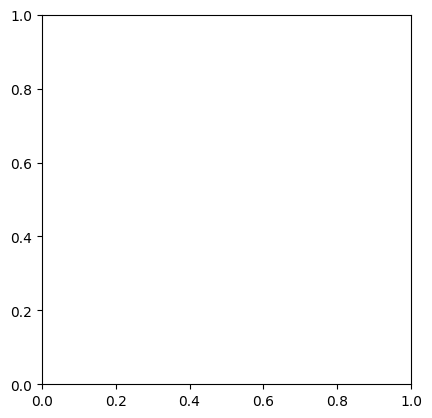

In [12]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Load the JSON file
with open('Dataset_mask/557334727.json', 'r') as file:
    data = json.load(file)

# Iterate over the data and print the masks
for key, value in data.items():
    print(f"Key: {key}")
    
    # Assuming the mask is a list of lists representing a 2D array
    mask = np.array(value)
    
    # Print the mask
    print(mask)
    
    # If you want to visualize the mask
    plt.imshow(mask, cmap='gray')
    plt.show()

Store canny edge

In [9]:
dataset_path = 'Dataset'
edge_path = 'Dataset_edge'
def get_edge_image(image, low_threshold, high_threshold):
    # Convert the image to grayscale if it's not already
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Canny edge detection
    edges = cv2.Canny(gray, low_threshold, high_threshold)
    
    return edges
#edge detection + padding immagini
for filename in os.listdir(dataset_path):
    if filename.endswith(('.jpg', '.jpeg', '.png')):
        input_image_path = os.path.join(dataset_path, filename)
        image = cv2.imread(input_image_path)
        # Ottieni l'immagine del bordo
        edge_image = get_edge_image(image, low_threshold=250, high_threshold=350)
        
        # Apply padding to the edge image
        max_height = 2108
        max_width = 2113
        padding_height = max(0, max_height - edge_image.shape[0])
        padding_width = max(0, max_width - edge_image.shape[1])
        edge_image_padded = cv2.copyMakeBorder(edge_image, 0, padding_height, 0, padding_width, cv2.BORDER_CONSTANT, value=0)
        
        # Salva l'immagine del bordo nella cartella di output
        output_image_path = os.path.join(edge_path, filename)
        cv2.imwrite(output_image_path, edge_image_padded)

print("Il rilevamento dei bordi è stato applicato a tutte le immagini nella cartella.")

Il rilevamento dei bordi è stato applicato a tutte le immagini nella cartella.


Dataset preparation

In [ ]:
# Custom dataset class
class ParkingLotDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transforms=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transforms = transforms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        # Load image
        image = cv2.imread(image_path)
        #image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load masks
        with open(mask_path, 'r') as f:
            masks_data = json.load(f)

        masks = []
        for shape in masks_data['shapes']:
            points = np.array(shape['points'])
            mask = np.zeros_like(image[:, :, 0])
            cv2.fillPoly(mask, [points.astype(np.int32)], 1)
            masks.append(mask)

        masks = np.stack(masks, axis=0).astype(np.float32)

        # Apply transformations
        if self.transforms:
            image = self.transforms(image)
            masks = self.transforms(masks)

        return image, masks

# Initialize variables to store max height and width
max_height = 0
max_width = 0

# Iterate through all images in the directory
for filename in os.listdir('C:/Users/loren/Downloads/APKLOT-master/APKLOT-master/1. Satellite/Dataset/parcheggi/dataloader'):
    if filename.endswith('.png') or filename.endswith('.jpg'):
        # Load the image
        image_path = os.path.join('C:/Users/loren/Downloads/APKLOT-master/APKLOT-master/1. Satellite/Dataset/parcheggi/dataloader', filename)
        image = cv2.imread(image_path)

        # Get height and width of the image
        height, width, _ = image.shape

        # Update max_height and max_width if necessary
        if height > max_height:
            max_height = height
        if width > max_width:
            max_width = width

print("Maximum Height:", max_height)
print("Maximum Width:", max_width)

# Data transformations
transform = transforms.Compose([
    transforms.Resize((max_height, max_width)),  # Resize to maximum dimensions
    transforms.Pad(padding),  # Pad images to make them all the same size
    transforms.ToTensor()
])

# Combine image and mask paths
image_paths = []
mask_paths = []
for filename in os.listdir('C:/Users/loren/Downloads/APKLOT-master/APKLOT-master/1. Satellite/Dataset/parcheggi/dataloader'):
    if filename.endswith('.png'):
        image_path = 'C:/Users/loren/Downloads/APKLOT-master/APKLOT-master/1. Satellite/Dataset/parcheggi/dataloader'+ '/' + filename
        mask_path = 'C:/Users/loren/Downloads/APKLOT-master/APKLOT-master/1. Satellite/Dataset/parcheggi/dataloader'+ '/' + filename.replace('.png', '.json')
        image_paths.append(image_path)
        mask_paths.append(mask_path)





DATASET CLASS

In [81]:
import os
import glob
from PIL import Image
class ParkingLotDataset(Dataset):
    def __init__(self, root_dir, pairs=None, transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms

        if pairs is None:
            # Get all image files
            self.image_paths = sorted(glob.glob(os.path.join(root_dir, '*.png')))

            # Get all mask files
            self.mask_paths = sorted(glob.glob(os.path.join(root_dir, '*.json')))

            # Pair image and mask files based on their filenames
            self.pairs = [(image_path, mask_path) for image_path in self.image_paths for mask_path in self.mask_paths if os.path.splitext(os.path.basename(image_path))[0] == os.path.splitext(os.path.basename(mask_path))[0]]
        else:
            self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        image_path, mask_path = self.pairs[idx]

         # Load image and convert from BGR to RGB
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Convert numpy array to PIL Image for transformations
        pil_image = Image.fromarray(image)
        # Apply transformations
        if self.transforms:
            pil_image = self.transforms(pil_image)
        image = np.array(pil_image)

        # Load masks
        with open(mask_path, 'r') as f:
            masks_data = json.load(f)

        masks = []
        for shape in masks_data['shapes']:
            points = np.array(shape['points'])
            mask = np.zeros_like(image[:, :, 0])
            cv2.fillPoly(mask, [points.astype(np.int32)], 1)
            masks.append(mask)

        masks = np.stack(masks, axis=0).astype(np.float32)

        # Swap axes of masks to match PyTorch's expectations
        masks = np.transpose(masks, (1, 2, 0))
        #facendo la transformazione anche sul mask mi dà un errore che non è iterabile
        #probabilmente bisogna applicare la transformazione sul mask in modo che abbia la stessa dimensione dell'immagine
        

        
            

        return image, masks

DATASET SLPIT

In [68]:
#controllo il massimo valore di altezza e larghezza per fare il padding
import cv2
import os

# Directory containing the images
data_dir = 'dataloader'

# Initialize variables to store max height and width
max_height = 0
max_width = 0

# Iterate through all images in the directory
for filename in os.listdir(data_dir):
    if filename.endswith('.png') or filename.endswith('.jpg'):
        # Load the image
        image_path = os.path.join(data_dir, filename)
        image = cv2.imread(image_path)

        # Get height and width of the image
        height, width, _ = image.shape

        # Update max_height and max_width if necessary
        if height > max_height:
            max_height = height
        if width > max_width:
            max_width = width

print("Maximum Height:", max_height)
print("Maximum Width:", max_width)

Maximum Height: 2108
Maximum Width: 2113


In [83]:
import random
from torch.utils.data import random_split
from torchvision.transforms import functional as F

# magari rifare il dataloader con due cartelle
image_path = 'dataloader'


class RescalePad:
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):
        w, h = image.size
        max_w, max_h = self.output_size
        padding = (0, 0, max_w - w, max_h - h)  # left, top, right, bottom
        image = F.pad(image, padding)
        return image

max_height = 2108
max_width = 2113
target_size = (max_width, max_height)

transform = transforms.Compose([
    #RescalePad(target_size),
    transforms.Resize((max_height, max_width)),
    transforms.ToTensor(),
    # Add other transforms here as needed
])


# Create the dataset
dataset = ParkingLotDataset(image_path, transforms=transform)

# Define the proportions for the split
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1


# Shuffle the dataset
random.shuffle(dataset.pairs)

# Calculate the sizes of each split
total_size = len(dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_pairs = dataset.pairs[:train_size]
val_pairs = dataset.pairs[train_size:train_size+val_size]
test_pairs = dataset.pairs[train_size+val_size:]

# Create datasets for each split
train_dataset = ParkingLotDataset(image_path, pairs=train_pairs, transforms=transform)
val_dataset = ParkingLotDataset(image_path, pairs=val_pairs, transforms=transform)
test_dataset = ParkingLotDataset(image_path, pairs=test_pairs, transforms=transform )

# Now you can create data loaders for each split
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) 
#print delle immagini
import matplotlib.pyplot as plt

# Display images and masks from the train data loader
for images, masks in train_loader:
    for i in range(images.size(0)):
        image = images[i].permute(1, 2, 0).numpy()
        mask = masks[i].permute(1, 2, 0).numpy()

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.imshow(image)
        ax1.set_title('Image')
        ax2.imshow(mask.squeeze(), cmap='gray')
        ax2.set_title('Mask')
        plt.show()
        break  # Display only one batch
    break  # Display only one batch  

RuntimeError: stack expects each tensor to be equal size, but got [3, 2108, 19] at entry 0 and [3, 2108, 4] at entry 1

Model

In [54]:
import torch
import torch.nn as nn
from torchvision.models.segmentation import fcn_resnet50


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Define the model
model = fcn_resnet50(pretrained=False, num_classes=2).to(device)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
# Training loop
for epoch in range(num_epochs):
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)['out']
        loss = criterion(outputs, masks)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print loss for every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

c:\Users\Federico\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Federico\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Federico/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:12<00:00, 8.40MB/s]


TypeError: Unexpected type <class 'numpy.ndarray'>

Train

In [17]:
# Define the number of epochs
num_epochs = 10

for epoch in range(num_epochs):
    # Training
    model.train()
    for images, targets in train_data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        for images, targets in val_data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            # You can add here code to compute metrics and print them


NameError: name 'model' is not defined